<a href="https://colab.research.google.com/github/somilasthana/MachineLearningSkills/blob/master/NLP_Tensorflow_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import tensorflow_datasets as tfds
import os

TensorFlow 2.x selected.


In [0]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
newsgroups_train = fetch_20newsgroups(subset='all')

In [0]:
cdata = {}
for target, content in zip(newsgroups_train.target_names, newsgroups_train.data):
  cdata.setdefault(target, [])
  cdata[target].append(content)

In [0]:
FILE_NAMES = []
for target in cdata:
    with open(target, "w") as fp:
      fp.write("\n".join(cdata[target]))
      FILE_NAMES.append("/content/"+target)

In [0]:
def labeler(example, index):
  return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
  lines_dataset = tf.data.TextLineDataset(file_name)
  labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
  labeled_data_sets.append(labeled_dataset)

In [0]:
BUFFER_SIZE = 50000
BATCH_SIZE = 16
TAKE_SIZE = 5000

In [0]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
  all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
  
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [17]:
for ex in all_labeled_data.take(5):
  print(ex)

(<tf.Tensor: id=2169, shape=(), dtype=string, numpy=b''>, <tf.Tensor: id=2170, shape=(), dtype=int64, numpy=17>)
(<tf.Tensor: id=2171, shape=(), dtype=string, numpy=b'Organization: University of East Anglia'>, <tf.Tensor: id=2172, shape=(), dtype=int64, numpy=19>)
(<tf.Tensor: id=2173, shape=(), dtype=string, numpy=b'Nntp-Posting-Host: stpl.ists.ca'>, <tf.Tensor: id=2174, shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: id=2175, shape=(), dtype=string, numpy=b''>, <tf.Tensor: id=2176, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=2177, shape=(), dtype=string, numpy=b'"In 1895, Karl Kellner (1850-1905), a wealthy Austrian industrialist'>, <tf.Tensor: id=2178, shape=(), dtype=int64, numpy=12>)


In [10]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
  some_tokens = tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

2288

In [0]:
encoder = tfds.features.text.SubwordTextEncoder(vocabulary_set)

In [18]:
text_tensor.numpy()

b'The word of Sin is Restriction. [Would I kid you?]'

In [0]:
encode_example = encoder.encode(text_tensor.numpy())

In [20]:
print(encode_example)

[75, 775, 1973, 775, 636, 775, 2126, 775, 664, 775, 1719, 2335, 2321, 2380, 1661, 775, 484, 775, 274, 775, 703, 2352, 2382]


In [0]:
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())
  return encoded_text, label

def encode_map_fn(text, label):
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

all_encoded_data = all_labeled_data.map(encode_map_fn)

In [0]:
train_data = all_encoded_data

In [0]:
padded_shapes = ([None],())
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)

In [0]:
vocab_size += 1 

In [0]:
from tensorflow import keras
from tensorflow.keras import layers

In [0]:
embedded_dim = 16

model = keras.Sequential(
    [
     layers.Embedding(encoder.vocab_size, embedded_dim),
     layers.GlobalAvgPool1D(),
     layers.Dense(1, activation='sigmoid')
    ]
)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          40720     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 40,737
Trainable params: 40,737
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
#history = model.fit(train_data, epochs=10, validation_data=train_batch, validation_steps=5)

history = model.fit(
    train_data,
    epochs=10)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
53/53 [==============================] - 3s 52ms/step - loss: -0.5246 - accuracy: 0.0358
Epoch 2/10
53/53 [==============================] - 1s 14ms/step - loss: -3.5542 - accuracy: 0.0346
Epoch 3/10
53/53 [==============================] - 1s 14ms/step - loss: -8.0612 - accuracy: 0.0346
Epoch 4/10
53/53 [==============================] - 1s 15ms/step - loss: -14.1704 - accuracy: 0.0346
Epoch 5/10
53/53 [==============================] - 1s 15ms/step - loss: -21.8879 - accuracy: 0.0346
Epoch 6/10
53/53 [==============================] - 1s 15ms/step - loss: -31.2265 - accuracy: 0.0346
Epoch 7/10
53/53 [==============================] - 1s 15ms/step - loss: -42.2129 - accuracy: 0.0346
Epoch 8/10
53/53 [==============================] - 1s 16ms/step - loss: -54.8650 - accuracy: 0.0346
Epoch 9/10
53/53 [==============================] - 1s 15ms/step - loss: -69.1816 - accuracy: 0.0346


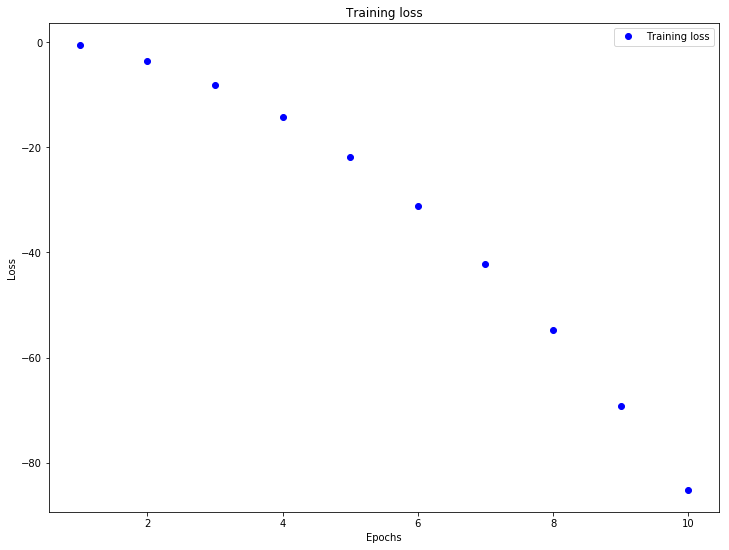

In [46]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
#val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
#val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2545, 16)


In [0]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')


for num, word in enumerate(encoder.subwords):
  vec = weights[num+1]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()


In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [0]:
# Use http://projector.tensorflow.org/ to view